<a href="https://colab.research.google.com/github/MatthewMoor/SOM-2.5PM/blob/master/SOMv8_1ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install somoclu

     |████████████████████████████████| 6.2MB 4.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/3c/e5/5b1c535e93453367a8e3d35a377d3c668da00369b1a4302ad8
Successfully built somoclu


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving BeijingPM2.csv to BeijingPM2.csv
Saving ChengduPM20.csv to ChengduPM20.csv
Saving GuangzhouPM20.csv to GuangzhouPM20.csv
Saving ShanghaiPM20.csv to ShanghaiPM20.csv
Saving ShenyangPM20.csv to ShenyangPM20.csv
User uploaded file "BeijingPM2.csv" with length 3173618 bytes
User uploaded file "ChengduPM20.csv" with length 3005479 bytes
User uploaded file "GuangzhouPM20.csv" with length 3351419 bytes
User uploaded file "ShanghaiPM20.csv" with length 3044776 bytes
User uploaded file "ShenyangPM20.csv" with length 3040703 bytes


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import somoclu
%matplotlib inline

In [5]:

data_bei = pd.read_csv('BeijingPM2.csv')
data_chen = pd.read_csv('ChengduPM20.csv')
data_guan = pd.read_csv('GuangzhouPM20.csv')
data_shan = pd.read_csv('ShanghaiPM20.csv')
data_shen = pd.read_csv('ShenyangPM20.csv')

datasets = [
    
    data_bei,
    data_chen,
    data_guan,
    data_shan,
    data_shen,
    
]

# describes our datasets
for i, u in enumerate(datasets):
    datasets[i] = u.dropna()
        
for i, data in enumerate(datasets):
    pollution_first = data.iloc[:, 6]
    pollution_second = data.iloc[:, 7]
    pollution_third = data.iloc[:, 8]
    PM = data.iloc[:, 6:9]
    
    if i == 0:
        pollution_fourth = data.iloc[:, 9]
        common_polution = (pollution_first + pollution_second + pollution_third + pollution_fourth) / 4
    else:
        common_polution = (pollution_first + pollution_second + pollution_third) / 3
        
    del datasets[i]['cbwd']
    del datasets[i]['No']
    datasets[i]['average_PM'] = common_polution

for i, data in enumerate(datasets):
    if i == 0:
        datasets[i] = data.drop(data.columns[[5, 6, 7, 8]], axis=1)
    else:
        datasets[i] = data.drop(data.columns[[5, 6, 7]], axis=1)
union = pd.concat(datasets, ignore_index=True)
labels = range(100685)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
def data_transformation(data=None, default_data = True): 
  """Transform data in the range 0, 1"""
  if data is None and default_data == True:
    X = pd.read_csv('dust_calculation.csv')
    X = X.iloc[:, 1:]
  else:
    X = data

  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler(feature_range = (0, 1))
  X = sc.fit_transform(X)
  print(np.shape(X))
  return X

def elbow_plot(X):
  """Draws plot with which we find the cluster"""
  Sum_of_squared_distances = []
  K = range(1,10)
  for k in K:
      km = KMeans(n_clusters=k).fit(X)
      km = km.fit(X)
      Sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()
  
def draw_umatrix(labels=None):
  if labels != None:
    return som.view_umatrix(bestmatches=True, labels=labels), som.view_component_planes()
  else:
    return som.view_umatrix(bestmatches=True), som.view_component_planes()

def get_coordinates_from_index(n, x, y):
    if n < 0:
        return (-1, -1)
    else:
        return (n % y, n // y)


def get_index_from_coordinates(c, x, y):
    if c[0] < 0 or c[1] < 0 or c[0] > y or c[1] > x:
        return -1
    else:
        return c[1]*y + c[0]


def get_neighbors_from_index(n, x, y):
    c = get_coordinates_from_index(n, x, y)
    neighbors_c = [(c[0]-1, c[1]), (c[0]+1, c[1]),
                   (c[0], c[1]-1), (c[0], c[1]+1)]
    neighbors_c = [c for c in neighbors_c
                   if c[0] >= 0 and c[1] >= 0 and c[1] < x and c[0] < y]
    neighbors = [get_index_from_coordinates(c, x, y) for c in neighbors_c]
    return list(set(neighbors))


def calculate_topographical_error(som, n_rows, n_columns):
    surface_state = som.get_surface_state()
    bmus_1st_and_2nd = np.argsort(surface_state, axis=1)[:, :2]
    all_2nd = []
    for i, second_index in enumerate(bmus_1st_and_2nd[:, 1]):
        all_2nd.append([])
        distance = surface_state[i, second_index]
        for s_i, s in enumerate(surface_state[i]):
            if abs(s-distance) < 10e-5:
                all_2nd[-1].append(s_i)
    neighbors = [get_neighbors_from_index(t, n_rows, n_columns)
                 for t in bmus_1st_and_2nd[:, 0]]

    e_t = 1-np.mean([len(set(second) & set(neighs)) > 0 for (second, neighs) in
                     zip(all_2nd, neighbors)])
    return e_t

def find_clusters(labels):
  """We find line our clusters of datasets"""
  clusters = {}
  for k in labels:  # The data instance you are interested in 
      cluster = str(som.clusters[som.bmus[k, 1], som.bmus[k, 0]])
      if not cluster in clusters.keys():
          clusters[cluster] = []
      clusters[cluster] += [k]
  import json
  print(json.dumps(clusters, sort_keys=True, indent=4))
  return clusters
  
    
 
  
def cluster_data(number_cluster, clusters):
  """Pulling out data-points in rows"""
  try:
    pulled_data = []
    detailed_cluster = clusters[number_cluster]
    for i in detailed_cluster:
      pulled_data.append(X[i])
  except KeyError:
    print('Your data out of range!\nSolution: Enter correct cluster value, your length dict - {}'.format(len(clusters.keys())))
   
  return np.asarray(pulled_data)

 
def quant_err(data, clusters = None):
    """ 
       Computes the quantization error of the SOM.
       It uses the data fed at last training.
    """
    if clusters == None: 
      bmu_dists = []
      bmus = som.get_bmus(som.get_surface_state(data))
      bmus_feat = som.codebook
      for index, input_vector in enumerate(data):
          bmu = bmus[index]
          bmu_feat = bmus_feat[bmu[0], bmu[1]]
          bmu_dists.append(np.linalg.norm(input_vector-bmu_feat))
      return np.array(bmu_dists).mean()
    else:
      cluster_bmu_dists = []
      for index_cluster in clusters:
        data_cluster = cluster_data(index_cluster, clusters)
        error_certain_cluster = quant_err(data_cluster)
        cluster_bmu_dists.append([index_cluster, error_certain_cluster])
      return np.array(cluster_bmu_dists)
        

In [7]:
n_rows, n_columns = 10, 10
X = data_transformation(union)
labels = range(X.shape[0])

som = somoclu.Somoclu(n_columns, n_rows, data=X, maptype="planar")
som.train(epochs=1,radius0=10, radiusN=1,radiuscooling="exponential",scale0=0.1, scaleN=0.09, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(100684, 13)
The topographical error obtained is: 0.08507806602836598


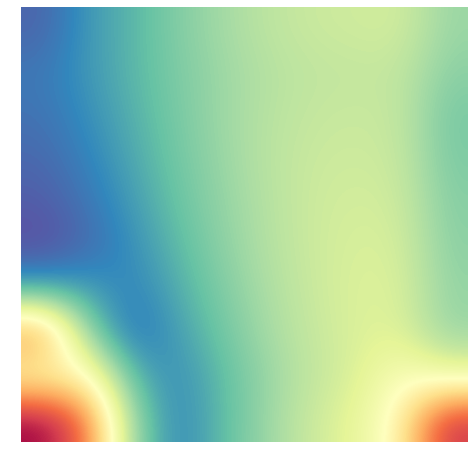

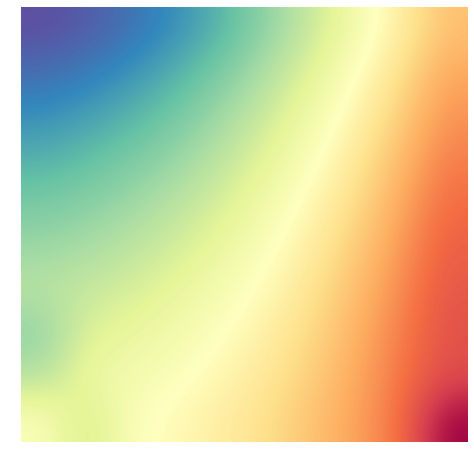

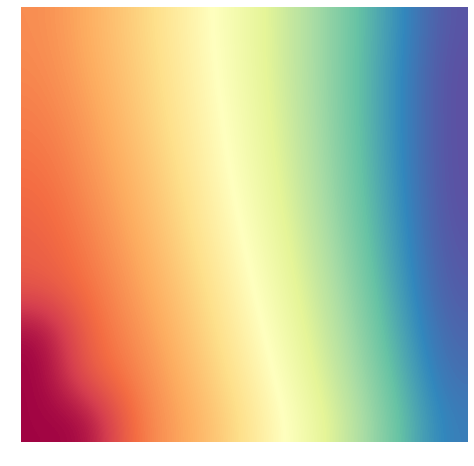

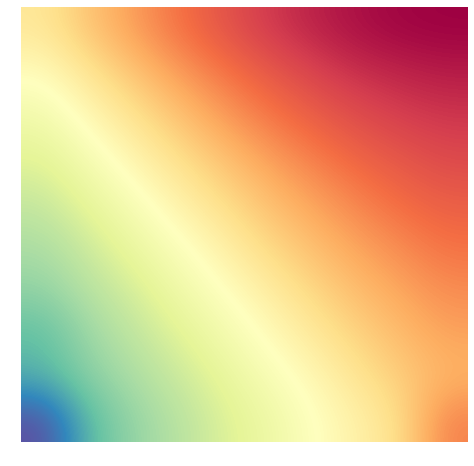

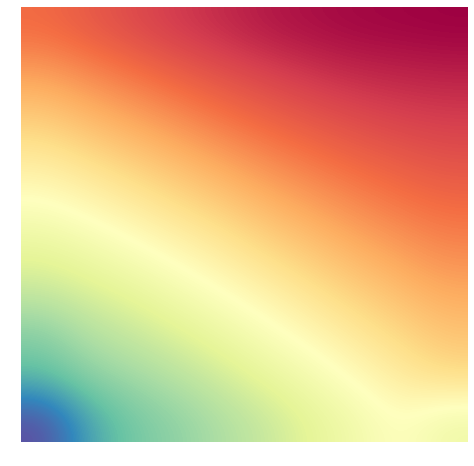

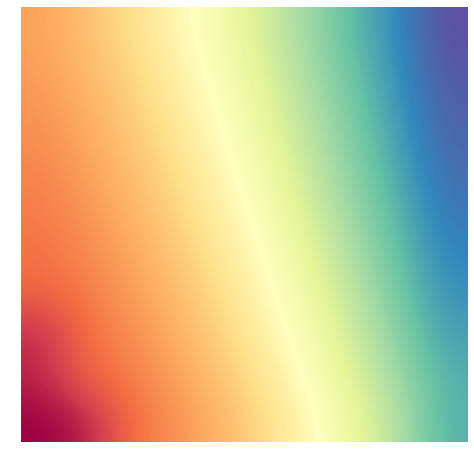

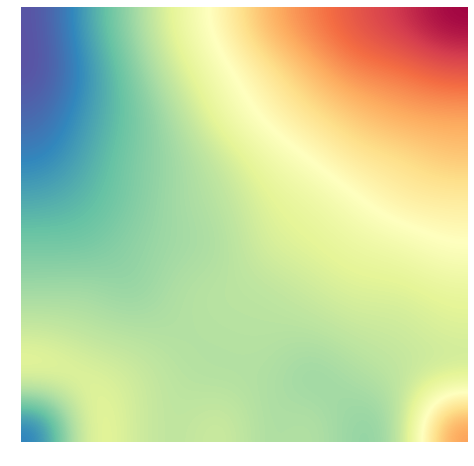

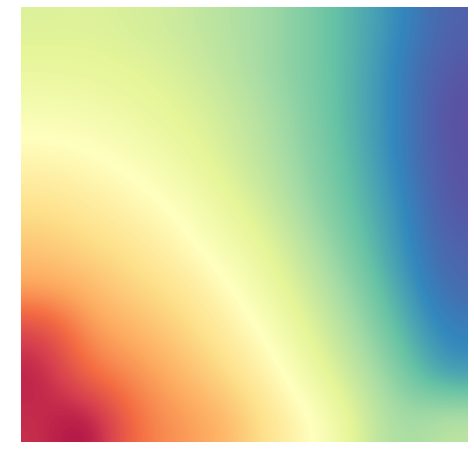

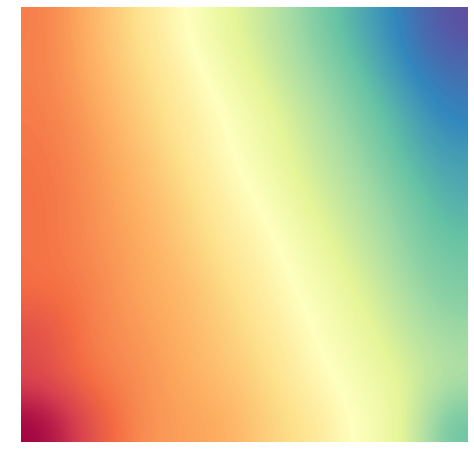

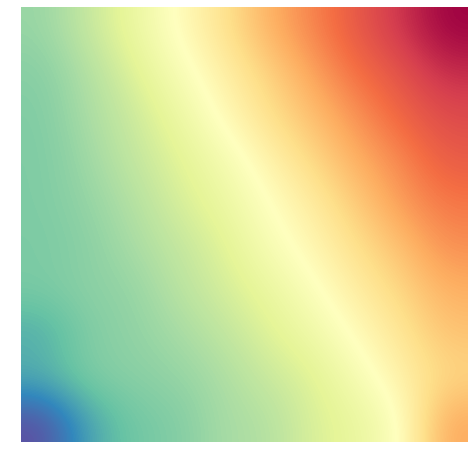

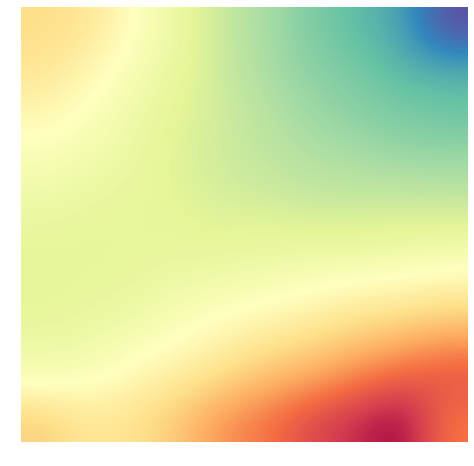

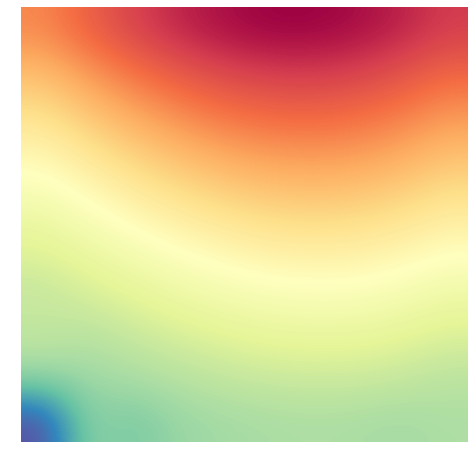

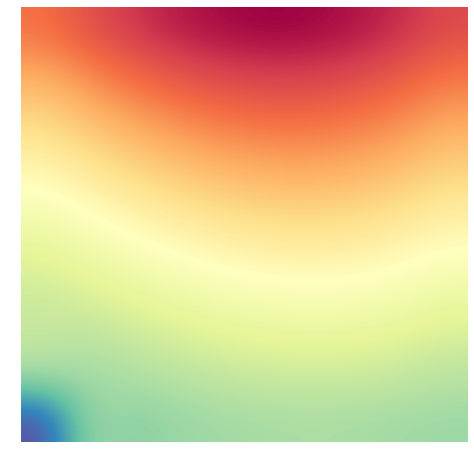

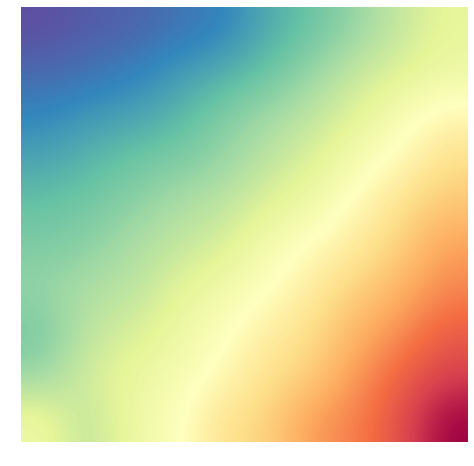

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som.view_umatrix()
som.view_component_planes()

In [0]:
%time som.train(epochs=15000,radius0=1,radiusN=0.000001,radiuscooling="exponential",scale0=0.035, scaleN=0.001, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

CPU times: user 1d 10h 59min 24s, sys: 1min 9s, total: 1d 11h 34s
Wall time: 8h 50min 18s
The topographical error obtained is: 0.5056712089309126


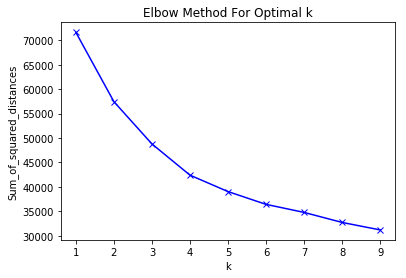

In [0]:
elbow_plot(X)

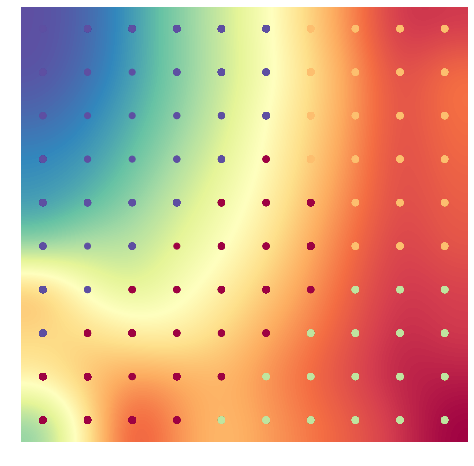

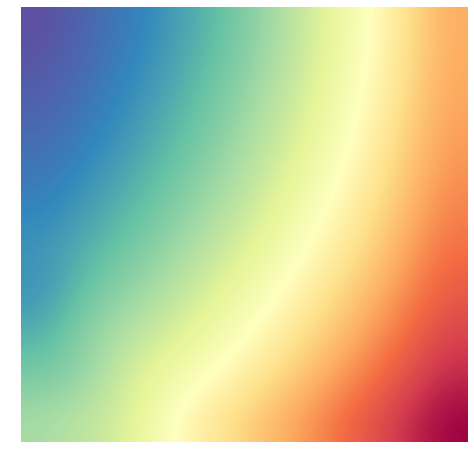

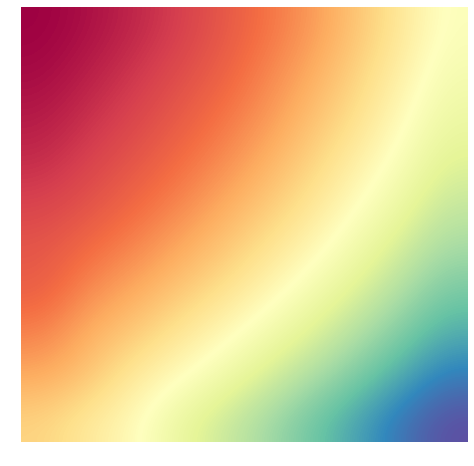

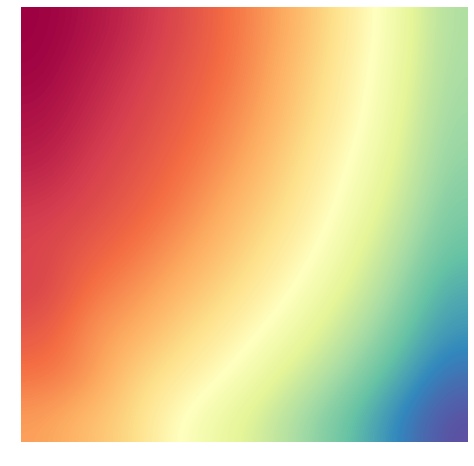

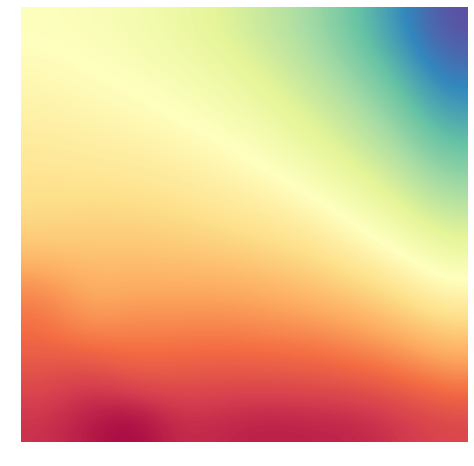

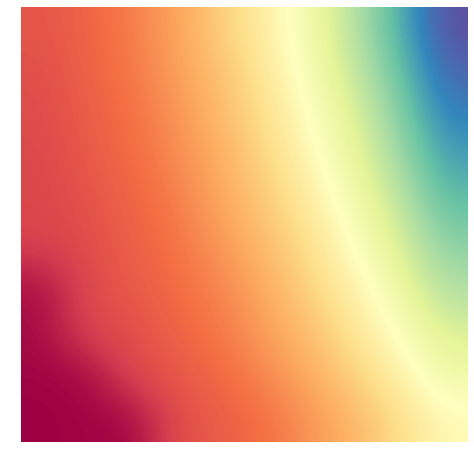

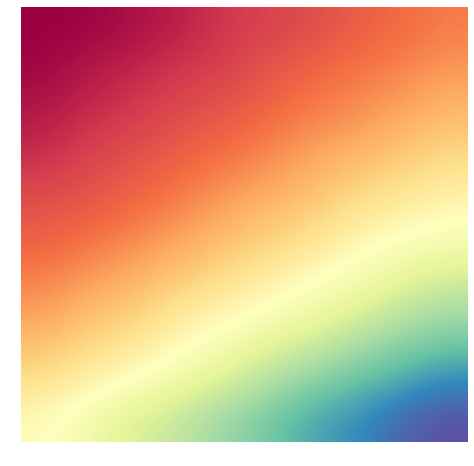

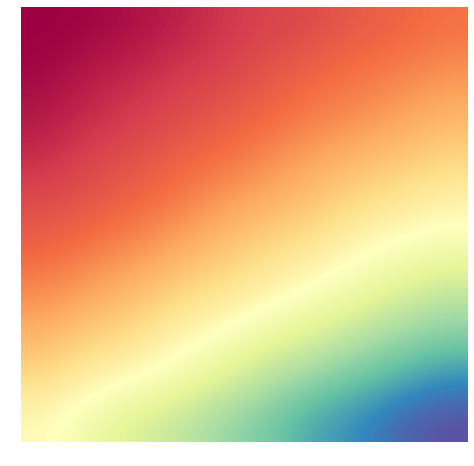

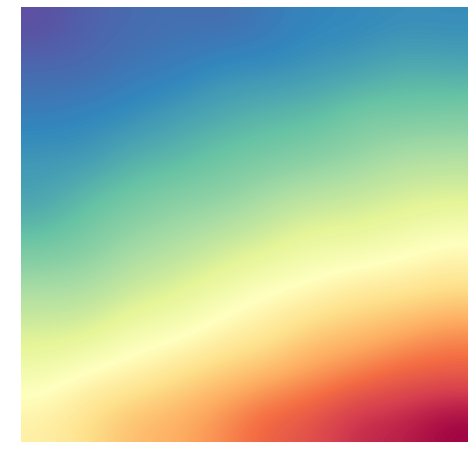

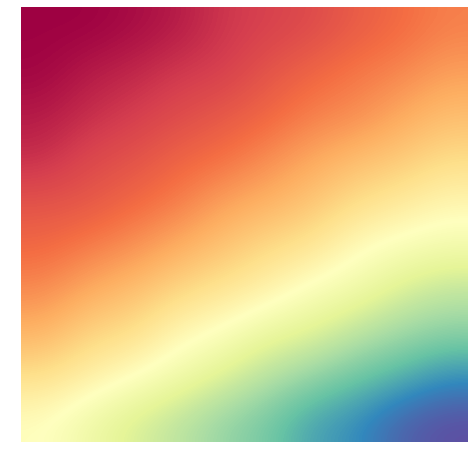

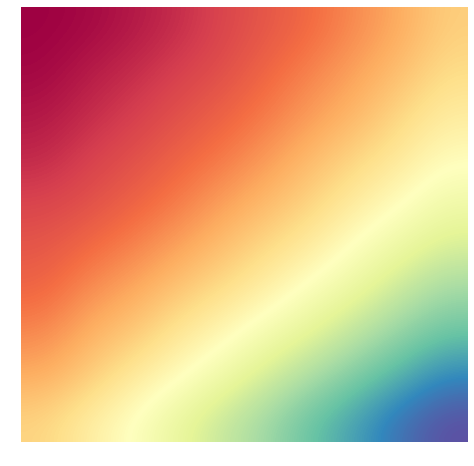

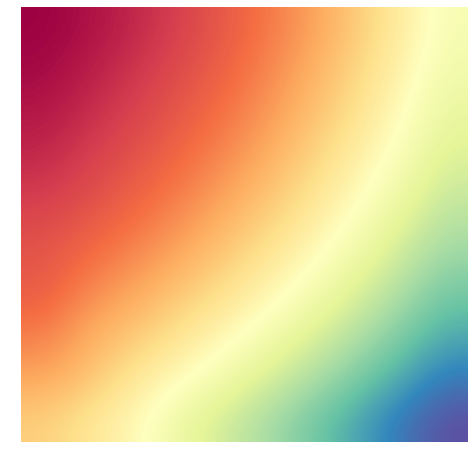

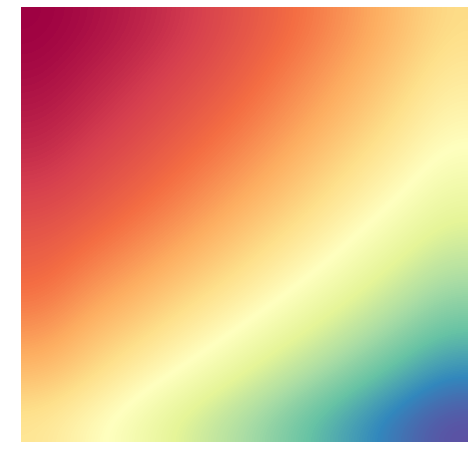

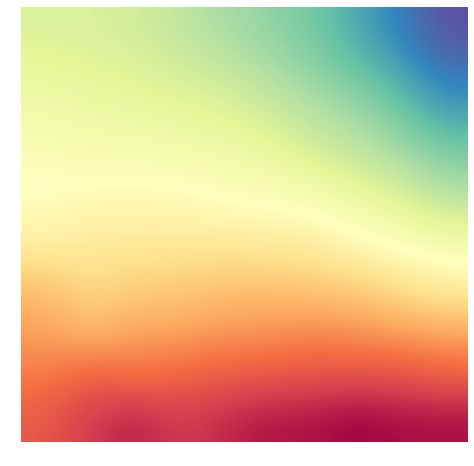

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>)

In [8]:
algorithm = KMeans(n_clusters = 4)
som.cluster(algorithm=algorithm)
draw_umatrix()

In [19]:
# We find own data-points for each clusters
clusters = find_clusters(labels)

{
    "0": [
        588,
        589,
        590,
        602,
        603,
        604,
        605,
        606,
        607,
        608,
        609,
        610,
        611,
        612,
        613,
        614,
        615,
        1084,
        1085,
        1086,
        1087,
        1088,
        1089,
        1090,
        1091,
        1092,
        1093,
        1106,
        1107,
        1108,
        1109,
        1110,
        1111,
        1112,
        1113,
        1114,
        1115,
        1174,
        1175,
        1176,
        1177,
        1178,
        1179,
        1197,
        1198,
        1199,
        1200,
        1201,
        1202,
        1203,
        1212,
        1213,
        1214,
        1215,
        1216,
        1217,
        1218,
        1219,
        1220,
        1260,
        1261,
        1477,
        1478,
        1479,
        1570,
        1571,
        1572,
        1573,
        1620,
        1639,
        1641,
        16

In [52]:
# specify_cluster = cluster_data('1', clusters)
quantization = quant_err(X, clusters)
print(quantization)
# Transform found data-points in the right view


[['2' '0.8087367212037525']
 ['1' '0.841943529087662']
 ['3' '0.9384785827883525']
 ['0' '0.7629961242632689']]


In [0]:
n_rows, n_columns = 29, 29
som = somoclu.Somoclu(n_columns, n_rows, data=specific_cluster, maptype="toroid")
%time som.train(epochs=1000,radius0=28, radiusN=1,radiuscooling="exponential",scale0=0.1, scaleN=0.035, scalecooling="exponential")

CPU times: user 16min 8s, sys: 1.01 s, total: 16min 9s
Wall time: 4min 21s


In [0]:
%time som.train(epochs=15000,radius0=1,radiusN=0.000001,radiuscooling="exponential",scale0=0.035, scaleN=0.001, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

CPU times: user 3h 33min 52s, sys: 11.3 s, total: 3h 34min 3s
Wall time: 57min 12s
The topographical error obtained is: 0.5046853273683574


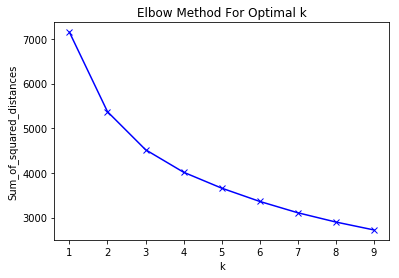

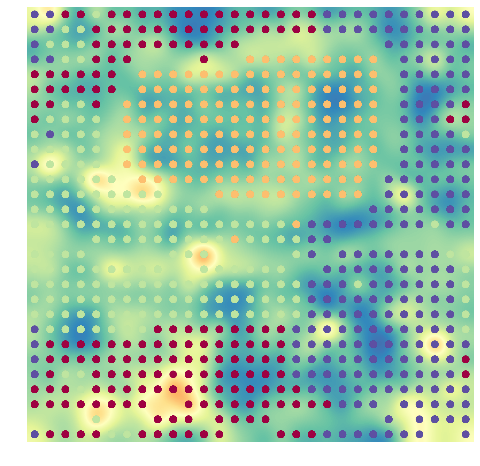

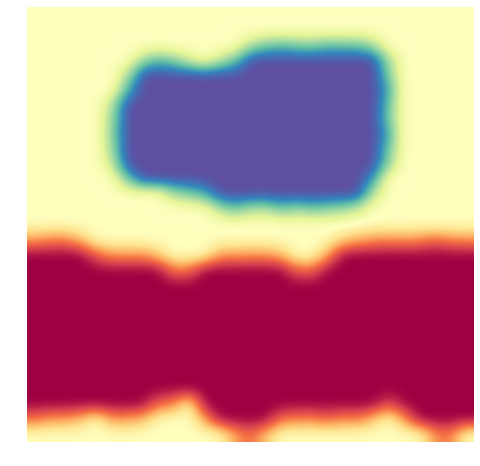

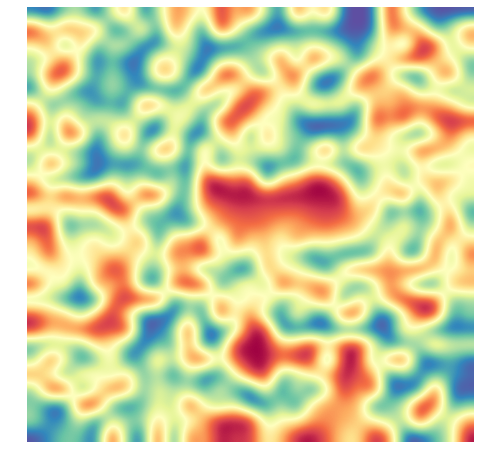

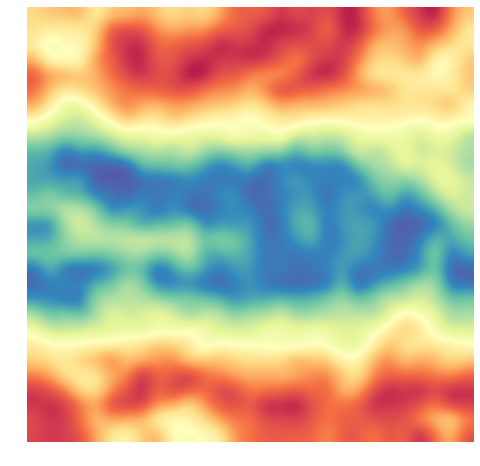

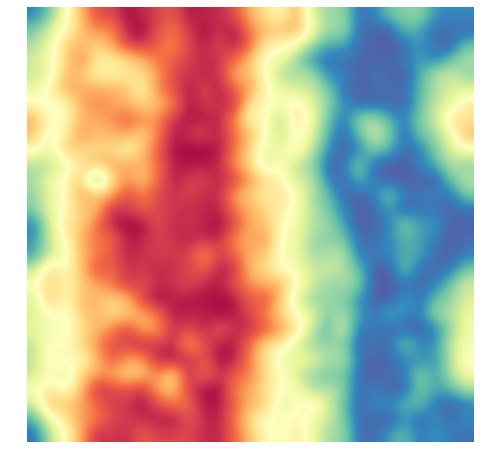

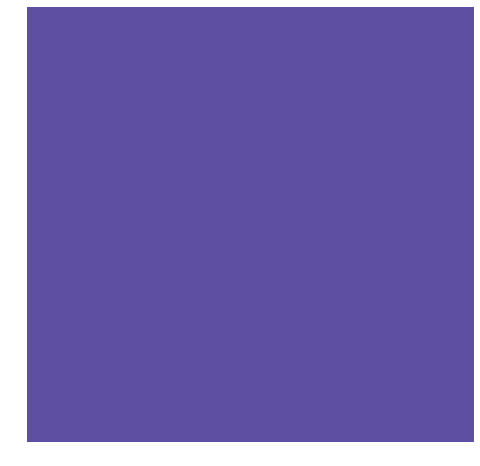

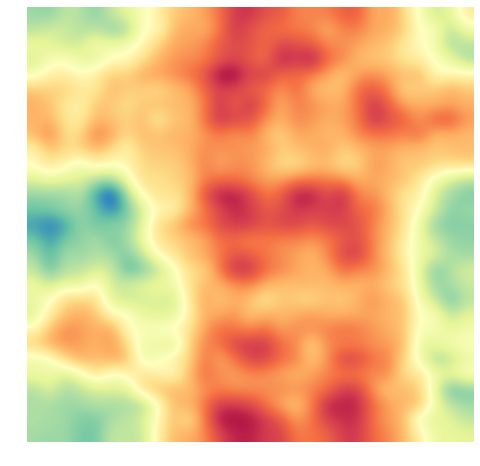

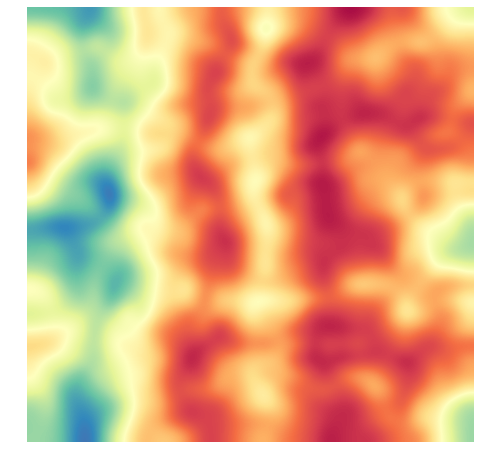

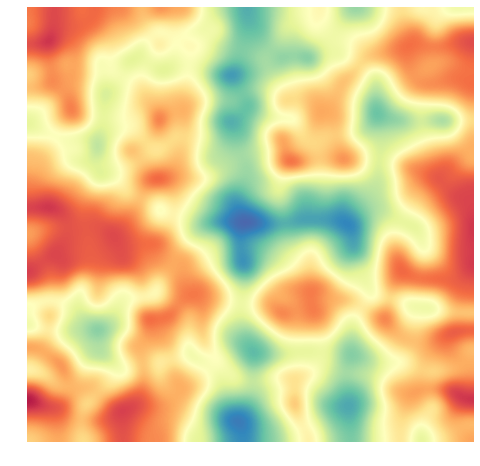

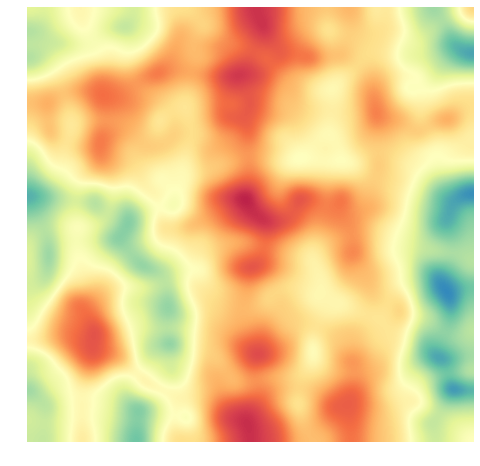

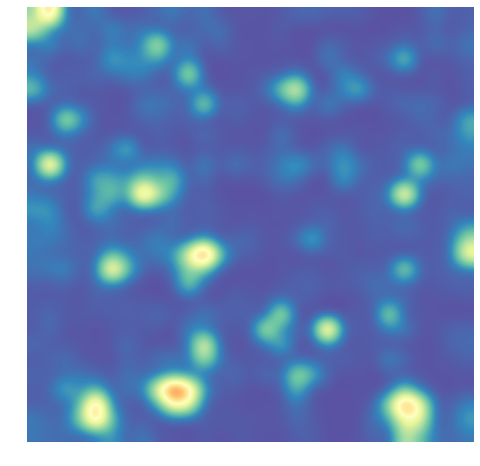

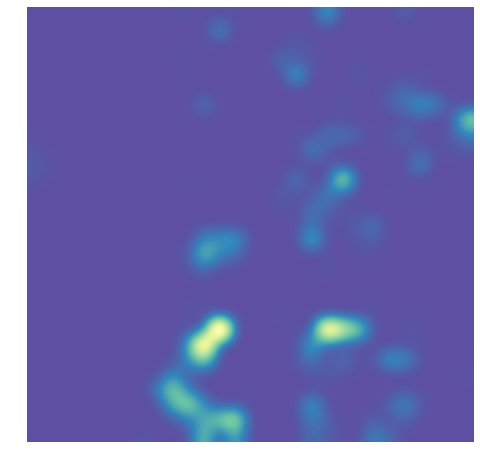

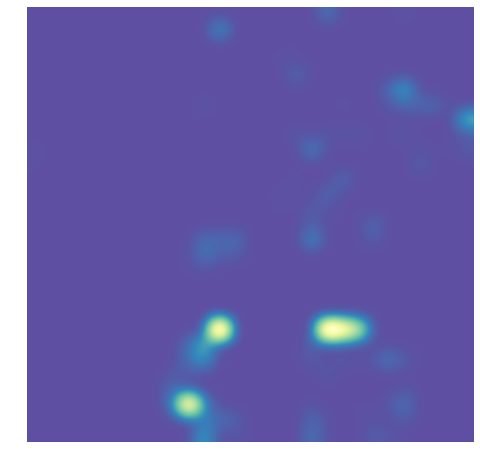

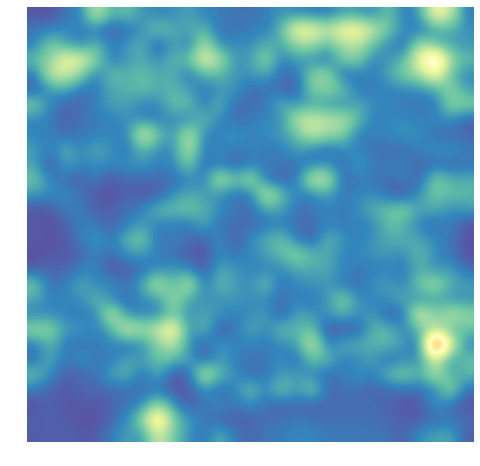

(<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

In [0]:
elbow_plot(specific_cluster)

algorithm = KMeans(n_clusters = 4)
som.cluster(algorithm=algorithm)
draw_umatrix()